# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [97]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [98]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [99]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-08-06 09:00:00+09:00,40430.460938,40581.460938,40423.128906,40581.460938,0,0.0,0.0
2025-08-06 09:15:00+09:00,40581.128906,40590.261719,40513.500000,40590.261719,0,0.0,0.0
2025-08-06 09:30:00+09:00,40590.839844,40590.839844,40497.550781,40538.460938,0,0.0,0.0
2025-08-06 09:45:00+09:00,40545.199219,40633.781250,40523.589844,40627.101562,0,0.0,0.0
2025-08-06 10:00:00+09:00,40621.000000,40644.550781,40584.750000,40596.699219,0,0.0,0.0
2025-08-06 10:15:00+09:00,40598.359375,40606.671875,40550.160156,40561.941406,0,0.0,0.0
2025-08-06 10:30:00+09:00,40560.449219,40708.058594,40556.460938,40695.261719,0,0.0,0.0
2025-08-06 10:45:00+09:00,40693.289062,40774.531250,40683.109375,40770.480469,0,0.0,0.0
2025-08-06 11:00:00+09:00,40768.351562,40779.820312,40759.640625,40759.640625,0,0.0,0.0


## 前日終値の取得

In [100]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period="1d", interval="1d", start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-08-05 00:00:00+09:00    40549.539062
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

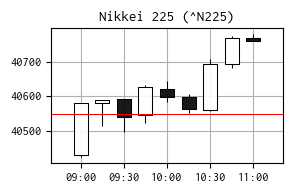

In [101]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()